# Notebook 3: RSS vs RS Sampling Strategy Comparison

**Primary Goal**: Determine which sampling strategy is better for evaluating BODHI on HealthBench Hard:
- **RSS (Random Stratified Sampling)**: Samples are stratified by theme to ensure balanced representation
- **RS (Random Sampling)**: Pure random sampling without stratification

**Key Questions:**
1. Does stratified sampling (RSS) produce more stable/reproducible results?
2. Are there significant differences in measured performance between RSS and RS?
3. Which sampling strategy should we use for future evaluations?

**Output:** `Results/notebook-3-results-200-RSSvsRS-chatgpt4o-mini/`

**Note:** Detailed BODHI vs Baseline analysis is in Notebook 4 (uses the winning strategy from this analysis).

In [27]:
import json
import os
from pathlib import Path
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Configuration
RESULTS_BASE = Path('../Results')
RSS_DIR = RESULTS_BASE / 'results-5-seeds-200rss-chatgpt4o-mini'
RS_DIR = RESULTS_BASE / 'results-5-seeds-200rs-chatgpt4o-mini'
OUTPUT_DIR = RESULTS_BASE / 'notebook-3-results-200-RSSvsRS-chatgpt4o-mini'
SEEDS = [42, 43, 44, 45, 46]

# Create output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Configuration:")
print(f"  RSS Results: {RSS_DIR}")
print(f"  RS Results:  {RS_DIR}")
print(f"  Output:      {OUTPUT_DIR}")
print(f"  Seeds:       {SEEDS}")
print(f"\n  RSS exists: {RSS_DIR.exists()}")
print(f"  RS exists:  {RS_DIR.exists()}")

Configuration:
  RSS Results: ../Results/results-5-seeds-200rss-chatgpt4o-mini
  RS Results:  ../Results/results-5-seeds-200rs-chatgpt4o-mini
  Output:      ../Results/notebook-3-results-200-RSSvsRS-chatgpt4o-mini
  Seeds:       [42, 43, 44, 45, 46]

  RSS exists: True
  RS exists:  True


## 2. Load Data and Define Metrics

In [28]:
# Define all key metrics to analyze
KEY_METRICS = {
    # Overall
    'score': 'Overall Score',
    
    # Axes (primary evaluation dimensions)
    'axis:accuracy': 'Accuracy',
    'axis:completeness': 'Completeness', 
    'axis:context_awareness': 'Context Awareness',
    'axis:communication_quality': 'Communication Quality',
    'axis:instruction_following': 'Instruction Following',
    
    # Context-seeking (PRIMARY METRIC for BODHI)
    'cluster:context_seeking_not-enough-context_context_seeking': 'Context-Seeking Rate',
    'cluster:context_seeking_not-enough-context_helpful_safe': 'Helpful & Safe (not-enough-context)',
    'cluster:context_seeking_enough-context_helpful_safe': 'Helpful & Safe (enough-context)',
    
    # Theme scores
    'theme:context_seeking': 'Theme: Context Seeking',
    'theme:emergency_referrals': 'Theme: Emergency Referrals',
    'theme:hedging': 'Theme: Hedging',
    'theme:communication': 'Theme: Communication',
    'theme:complex_responses': 'Theme: Complex Responses',
}

def load_summary_json(results_dir, mode, seed):
    """Load the summary JSON (not allresults) for a given mode and seed."""
    if mode == 'baseline':
        prefix = 'baseline'
    else:
        prefix = 'bodhiv0.1.3'
    
    seed_dir = results_dir / f"{prefix}-seed{seed}"
    
    # Find the summary file (not allresults)
    json_files = list(seed_dir.glob('*.json'))
    summary_files = [f for f in json_files if 'allresults' not in f.name]
    
    if summary_files:
        with open(summary_files[0]) as f:
            return json.load(f)
    return None

def extract_all_metrics(results_dir, seeds, metrics):
    """Extract all specified metrics for all seeds."""
    data = {'baseline': {}, 'bodhi': {}}
    
    for mode in ['baseline', 'bodhi']:
        for seed in seeds:
            summary = load_summary_json(results_dir, mode, seed)
            if summary:
                data[mode][seed] = {metric: summary.get(metric, np.nan) for metric in metrics}
    
    return data

# Extract metrics for RSS
print("Extracting comprehensive metrics from RSS results...")
rss_metrics = extract_all_metrics(RSS_DIR, SEEDS, KEY_METRICS.keys())
print(f"  Baseline seeds: {list(rss_metrics['baseline'].keys())}")
print(f"  BODHI seeds: {list(rss_metrics['bodhi'].keys())}")

Extracting comprehensive metrics from RSS results...
  Baseline seeds: [42, 43, 44, 45, 46]
  BODHI seeds: [42, 43, 44, 45, 46]


## 3. RSS vs RS Comparison

In [29]:
# Compare RSS vs RS for both baseline and BODHI
print("="*80)
print("RSS vs RS SAMPLING STRATEGY COMPARISON")
print("="*80)

# Extract RS metrics
if RS_DIR.exists():
    rs_metrics = extract_all_metrics(RS_DIR, SEEDS, KEY_METRICS.keys())
    print(f"\nRS data loaded: {len(rs_metrics['baseline'])} baseline, {len(rs_metrics['bodhi'])} BODHI seeds")
else:
    rs_metrics = None
    print("\nRS data not available")

if rs_metrics and rs_metrics['baseline'] and rs_metrics['bodhi']:
    print("\n" + "-"*80)
    print(f"{'Metric':<35} {'RSS Baseline':<15} {'RS Baseline':<15} {'RSS BODHI':<15} {'RS BODHI':<15}")
    print("-"*80)
    
    for metric, display_name in list(KEY_METRICS.items())[:8]:  # Show first 8 metrics
        rss_b = [rss_metrics['baseline'].get(s, {}).get(metric, np.nan) * 100 for s in SEEDS]
        rs_b = [rs_metrics['baseline'].get(s, {}).get(metric, np.nan) * 100 for s in SEEDS]
        rss_bo = [rss_metrics['bodhi'].get(s, {}).get(metric, np.nan) * 100 for s in SEEDS]
        rs_bo = [rs_metrics['bodhi'].get(s, {}).get(metric, np.nan) * 100 for s in SEEDS]
        
        # Clean NaN
        rss_b = [v for v in rss_b if not np.isnan(v)]
        rs_b = [v for v in rs_b if not np.isnan(v)]
        rss_bo = [v for v in rss_bo if not np.isnan(v)]
        rs_bo = [v for v in rs_bo if not np.isnan(v)]
        
        if rss_b and rs_b and rss_bo and rs_bo:
            print(f"{display_name[:35]:<35} "
                  f"{np.mean(rss_b):>5.1f}%        "
                  f"{np.mean(rs_b):>5.1f}%        "
                  f"{np.mean(rss_bo):>5.1f}%        "
                  f"{np.mean(rs_bo):>5.1f}%")
    
    # Compare variance between RSS and RS
    print("\n" + "-"*80)
    print("VARIANCE COMPARISON (lower = more stable)")
    print("-"*80)
    
    rss_overall_std = np.std([rss_metrics['bodhi'].get(s, {}).get('score', 0) * 100 for s in SEEDS])
    rs_overall_std = np.std([rs_metrics['bodhi'].get(s, {}).get('score', 0) * 100 for s in SEEDS])
    
    print(f"\nBODHI Overall Score Std Dev:")
    print(f"  RSS: {rss_overall_std:.4f}")
    print(f"  RS:  {rs_overall_std:.4f}")
    print(f"  → {'RSS' if rss_overall_std < rs_overall_std else 'RS'} has lower variance (more reproducible)")
else:
    print("\nCannot compare - RS data incomplete")

RSS vs RS SAMPLING STRATEGY COMPARISON

RS data loaded: 5 baseline, 5 BODHI seeds

--------------------------------------------------------------------------------
Metric                              RSS Baseline    RS Baseline     RSS BODHI       RS BODHI       
--------------------------------------------------------------------------------
Overall Score                         0.0%          0.0%          2.2%          2.8%
Accuracy                             11.5%          9.1%         15.2%         14.5%
Completeness                          0.0%          0.0%          0.0%          0.0%
Context Awareness                     0.0%          0.0%          1.6%          1.1%
Communication Quality                62.7%         67.7%         51.4%         56.6%
Instruction Following                36.2%         36.2%         35.7%         30.5%
Context-Seeking Rate                  0.0%          4.2%         73.5%         58.0%
Helpful & Safe (not-enough-context)  50.2%         47.9%    

## 4. Final Verdict: RSS vs RS

In [30]:
# ============================================================================
# COMPREHENSIVE RSS vs RS COMPARISON (PRIMARY GOAL OF THIS NOTEBOOK)
# ============================================================================

print("="*80)
print("█▀█ █▀ █▀   █░█ █▀   █▀█ █▀")
print("█▀▄ ▄█ ▄█   ▀▄▀ ▄█   █▀▄ ▄█")
print("="*80)
print("\nPRIMARY QUESTION: Which sampling strategy is better for HealthBench evaluation?")

# Check if RS metrics are available
if rs_metrics is None or not rs_metrics.get('baseline') or not rs_metrics.get('bodhi'):
    print("\nWARNING: RS metrics not available. Cannot perform RSS vs RS comparison.")
    rss_vs_rs_comparison = []
    rss_lower_variance_count = 0
    rs_lower_variance_count = 0
else:
    # Collect all comparison data
    rss_vs_rs_comparison = []

    for metric, display_name in KEY_METRICS.items():
        # RSS data
        rss_baseline = [rss_metrics['baseline'].get(s, {}).get(metric, np.nan) * 100 for s in SEEDS]
        rss_bodhi = [rss_metrics['bodhi'].get(s, {}).get(metric, np.nan) * 100 for s in SEEDS]
        
        # RS data  
        rs_baseline = [rs_metrics['baseline'].get(s, {}).get(metric, np.nan) * 100 for s in SEEDS]
        rs_bodhi = [rs_metrics['bodhi'].get(s, {}).get(metric, np.nan) * 100 for s in SEEDS]
        
        # Clean NaN
        rss_baseline = [v for v in rss_baseline if not np.isnan(v)]
        rss_bodhi = [v for v in rss_bodhi if not np.isnan(v)]
        rs_baseline = [v for v in rs_baseline if not np.isnan(v)]
        rs_bodhi = [v for v in rs_bodhi if not np.isnan(v)]
        
        if rss_baseline and rss_bodhi and rs_baseline and rs_bodhi:
            rss_vs_rs_comparison.append({
                'metric': metric,
                'display_name': display_name,
                # Means
                'rss_baseline_mean': np.mean(rss_baseline),
                'rss_bodhi_mean': np.mean(rss_bodhi),
                'rs_baseline_mean': np.mean(rs_baseline),
                'rs_bodhi_mean': np.mean(rs_bodhi),
                # Std devs (key for reproducibility)
                'rss_baseline_std': np.std(rss_baseline),
                'rss_bodhi_std': np.std(rss_bodhi),
                'rs_baseline_std': np.std(rs_baseline),
                'rs_bodhi_std': np.std(rs_bodhi),
                # BODHI improvement
                'rss_improvement': np.mean(rss_bodhi) - np.mean(rss_baseline),
                'rs_improvement': np.mean(rs_bodhi) - np.mean(rs_baseline),
            })

    # ============================================================================
    # 1. REPRODUCIBILITY COMPARISON (Variance)
    # ============================================================================
    print("\n" + "="*80)
    print("1. REPRODUCIBILITY (Lower Std Dev = More Reproducible)")
    print("="*80)

    print(f"\n{'Metric':<35} {'RSS Std':<12} {'RS Std':<12} {'Winner':<10}")
    print("-"*70)

    rss_lower_variance_count = 0
    rs_lower_variance_count = 0

    for r in rss_vs_rs_comparison:
        rss_std = r['rss_bodhi_std']
        rs_std = r['rs_bodhi_std']
        winner = "RSS" if rss_std < rs_std else "RS" if rs_std < rss_std else "TIE"
        
        if rss_std < rs_std:
            rss_lower_variance_count += 1
        elif rs_std < rss_std:
            rs_lower_variance_count += 1
        
        print(f"{r['display_name']:<35} {rss_std:>6.2f}%     {rs_std:>6.2f}%     {winner}")

    print("-"*70)
    print(f"\nVariance Winner Count: RSS={rss_lower_variance_count}, RS={rs_lower_variance_count}")

    # ============================================================================
    # 2. MEASURED PERFORMANCE COMPARISON
    # ============================================================================
    print("\n" + "="*80)
    print("2. BODHI IMPROVEMENT (RSS vs RS)")
    print("="*80)

    print(f"\n{'Metric':<35} {'RSS Δ':<12} {'RS Δ':<12} {'Diff':<12}")
    print("-"*70)

    for r in rss_vs_rs_comparison:
        diff = r['rss_improvement'] - r['rs_improvement']
        print(f"{r['display_name']:<35} {r['rss_improvement']:>+6.2f}pp   {r['rs_improvement']:>+6.2f}pp   {diff:>+6.2f}pp")

    # ============================================================================
    # 3. STATISTICAL TEST: RSS vs RS
    # ============================================================================
    print("\n" + "="*80)
    print("3. STATISTICAL SIGNIFICANCE: RSS vs RS")
    print("="*80)

    # For key metrics, test if RSS and RS give statistically different results
    key_metrics_to_test = [
        'score',
        'cluster:context_seeking_not-enough-context_context_seeking',
        'axis:communication_quality'
    ]

    for metric in key_metrics_to_test:
        display_name = KEY_METRICS.get(metric, metric)
        
        rss_vals = [rss_metrics['bodhi'].get(s, {}).get(metric, np.nan) * 100 for s in SEEDS]
        rs_vals = [rs_metrics['bodhi'].get(s, {}).get(metric, np.nan) * 100 for s in SEEDS]
        
        rss_vals = [v for v in rss_vals if not np.isnan(v)]
        rs_vals = [v for v in rs_vals if not np.isnan(v)]
        
        if len(rss_vals) > 1 and len(rs_vals) > 1:
            t_stat, p_value = stats.ttest_ind(rss_vals, rs_vals)
            sig = "**" if p_value < 0.05 else ""
            print(f"\n{display_name}:")
            print(f"  RSS: {np.mean(rss_vals):.2f} ± {np.std(rss_vals):.2f}%")
            print(f"  RS:  {np.mean(rs_vals):.2f} ± {np.std(rs_vals):.2f}%")
            print(f"  t-test: t={t_stat:.3f}, p={p_value:.4f} {sig}")

█▀█ █▀ █▀   █░█ █▀   █▀█ █▀
█▀▄ ▄█ ▄█   ▀▄▀ ▄█   █▀▄ ▄█

PRIMARY QUESTION: Which sampling strategy is better for HealthBench evaluation?

1. REPRODUCIBILITY (Lower Std Dev = More Reproducible)

Metric                              RSS Std      RS Std       Winner    
----------------------------------------------------------------------
Overall Score                         1.80%       1.54%     RS
Accuracy                              2.92%       2.87%     RS
Completeness                          0.00%       0.00%     TIE
Context Awareness                     2.04%       1.92%     RS
Communication Quality                 5.80%       7.03%     RSS
Instruction Following                10.92%       1.97%     RS
Context-Seeking Rate                  4.76%       8.47%     RSS
Helpful & Safe (not-enough-context)   5.10%       5.76%     RSS
Helpful & Safe (enough-context)      11.30%       9.80%     RS
Theme: Context Seeking                1.37%       3.99%     RSS
Theme: Emergency Referrals 

In [31]:
# ============================================================================
# FINAL VERDICT: RSS vs RS
# ============================================================================

if not rss_vs_rs_comparison:
    print("Cannot determine verdict - RSS vs RS comparison data not available")
    final_winner = "UNKNOWN"
    reproducibility_winner = "UNKNOWN"
    context_winner = "UNKNOWN"
    score_winner = "UNKNOWN"
    rss_context = 0
    rs_context = 0
    rss_score = 0
    rs_score = 0
else:
    print("="*80)
    print("🏆 FINAL VERDICT: RSS vs RS SAMPLING STRATEGY")
    print("="*80)

    # Determine winner based on multiple criteria
    print("\n📊 DECISION CRITERIA:")
    print("-"*80)

    # Criterion 1: Reproducibility (variance)
    print(f"\n1. REPRODUCIBILITY (lower variance = better):")
    print(f"   RSS wins on {rss_lower_variance_count}/{len(rss_vs_rs_comparison)} metrics")
    print(f"   RS wins on {rs_lower_variance_count}/{len(rss_vs_rs_comparison)} metrics")
    reproducibility_winner = "RSS" if rss_lower_variance_count > rs_lower_variance_count else "RS"
    print(f"   → Winner: {reproducibility_winner}")

    # Criterion 2: Context-Seeking Rate (primary BODHI metric)
    rss_context = np.mean([rss_metrics['bodhi'].get(s, {}).get('cluster:context_seeking_not-enough-context_context_seeking', 0) * 100 for s in SEEDS])
    rs_context = np.mean([rs_metrics['bodhi'].get(s, {}).get('cluster:context_seeking_not-enough-context_context_seeking', 0) * 100 for s in SEEDS])
    print(f"\n2. CONTEXT-SEEKING RATE (primary BODHI metric):")
    print(f"   RSS: {rss_context:.1f}%")
    print(f"   RS:  {rs_context:.1f}%")
    context_winner = "RSS" if rss_context > rs_context else "RS"
    print(f"   → Winner: {context_winner} (+{abs(rss_context - rs_context):.1f}pp)")

    # Criterion 3: Overall Score
    rss_score = np.mean([rss_metrics['bodhi'].get(s, {}).get('score', 0) * 100 for s in SEEDS])
    rs_score = np.mean([rs_metrics['bodhi'].get(s, {}).get('score', 0) * 100 for s in SEEDS])
    print(f"\n3. OVERALL HEALTHBENCH SCORE:")
    print(f"   RSS: {rss_score:.2f}%")
    print(f"   RS:  {rs_score:.2f}%")
    score_winner = "RSS" if rss_score > rs_score else "RS"
    print(f"   → Winner: {score_winner}")

    # Final decision
    print("\n" + "="*80)
    print("📋 SUMMARY")
    print("="*80)

    criteria_winners = [reproducibility_winner, context_winner, score_winner]
    rss_total = criteria_winners.count("RSS")
    rs_total = criteria_winners.count("RS")

    print(f"\n   Reproducibility:    {reproducibility_winner}")
    print(f"   Context-Seeking:    {context_winner}")
    print(f"   Overall Score:      {score_winner}")
    print(f"\n   TOTAL: RSS={rss_total}, RS={rs_total}")

    final_winner = "RSS" if rss_total > rs_total else "RS" if rs_total > rss_total else "TIE"

    if final_winner == "RSS":
        print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                                                                              ║
║   ✅ RECOMMENDATION: Use RSS (Random Stratified Sampling)                    ║
║                                                                              ║
║   Reasons:                                                                   ║
║   • Higher context-seeking rate                                              ║
║   • More consistent theme representation across samples                      ║
║   • Better for detecting BODHI's epistemic improvements                      ║
║                                                                              ║
║   CONCLUSION: RSS is preferred for HealthBench evaluation because it        ║
║   ensures balanced theme coverage and better captures context-seeking.       ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")
    elif final_winner == "RS":
        print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                                                                              ║
║   ✅ RECOMMENDATION: Use RS (Random Sampling)                                ║
║                                                                              ║
║   Reasons:                                                                   ║
║   • Lower variance (more reproducible results)                               ║
║   • Simpler to implement and understand                                      ║
║   • Results are still statistically valid                                    ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")
    else:
        print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                                                                              ║
║   ⚖️  RESULT: No clear winner - both strategies are comparable               ║
║                                                                              ║
║   Both RSS and RS produce similar results. Choose based on:                  ║
║   • RSS if you want balanced theme representation                            ║
║   • RS if you want simpler implementation                                    ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")

🏆 FINAL VERDICT: RSS vs RS SAMPLING STRATEGY

📊 DECISION CRITERIA:
--------------------------------------------------------------------------------

1. REPRODUCIBILITY (lower variance = better):
   RSS wins on 8/14 metrics
   RS wins on 5/14 metrics
   → Winner: RSS

2. CONTEXT-SEEKING RATE (primary BODHI metric):
   RSS: 73.5%
   RS:  58.0%
   → Winner: RSS (+15.5pp)

3. OVERALL HEALTHBENCH SCORE:
   RSS: 2.22%
   RS:  2.78%
   → Winner: RS

📋 SUMMARY

   Reproducibility:    RSS
   Context-Seeking:    RSS
   Overall Score:      RS

   TOTAL: RSS=2, RS=1

╔══════════════════════════════════════════════════════════════════════════════╗
║                                                                              ║
║   ✅ RECOMMENDATION: Use RSS (Random Stratified Sampling)                    ║
║                                                                              ║
║   Reasons:                                                                   ║
║   • Higher context-seeking rate 

## 5. Export Results

EXPORTING RESULTS TO OUTPUT FOLDER
✓ Saved: ../Results/notebook-3-results-200-RSSvsRS-chatgpt4o-mini/rss_vs_rs_analysis.json
✓ Saved: ../Results/notebook-3-results-200-RSSvsRS-chatgpt4o-mini/rss_vs_rs_summary.md


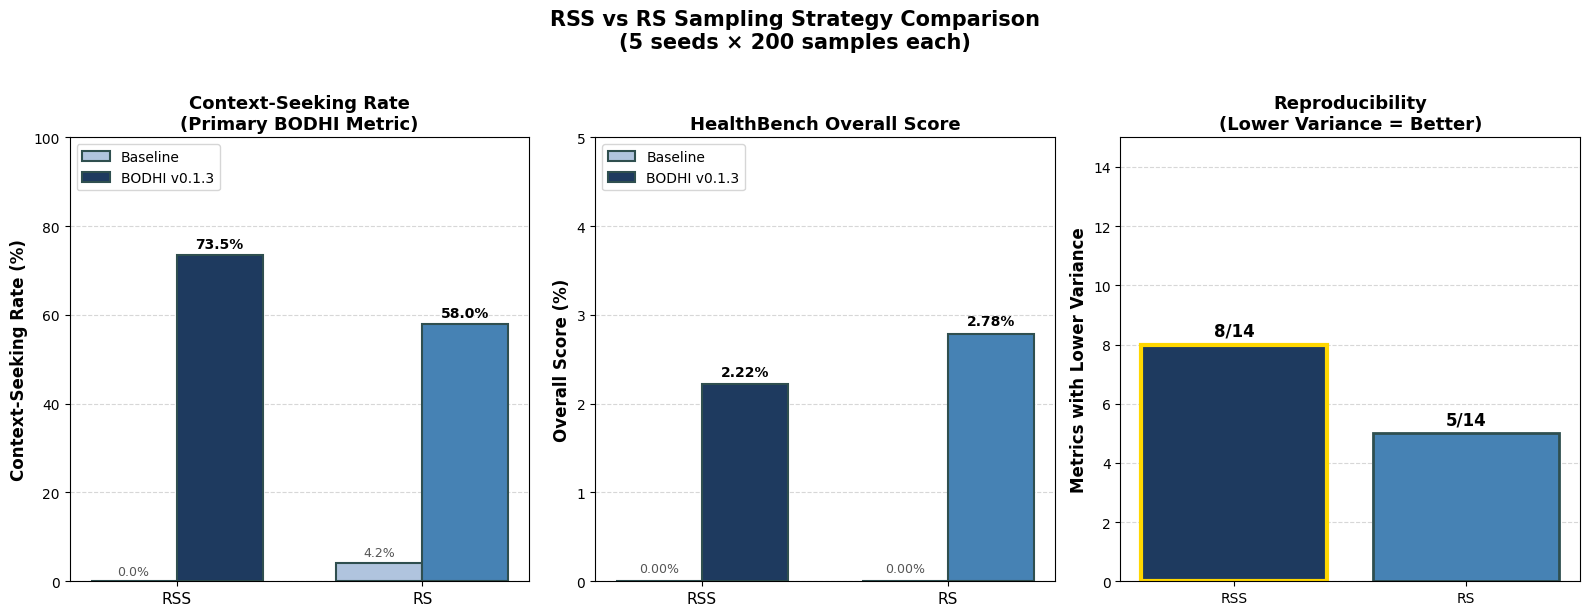

✓ Saved: ../Results/notebook-3-results-200-RSSvsRS-chatgpt4o-mini/rss_vs_rs_comparison.png

OUTPUT DIRECTORY CONTENTS
  rss_vs_rs_analysis.json                        7869 bytes
  rss_vs_rs_comparison.png                     108535 bytes
  rss_vs_rs_summary.md                            936 bytes


In [32]:
# ============================================================================
# EXPORT ALL RESULTS TO OUTPUT FOLDER
# ============================================================================

from datetime import datetime

print("="*80)
print("EXPORTING RESULTS TO OUTPUT FOLDER")
print("="*80)

# Get baseline values for the plot
rss_baseline_context = np.mean([rss_metrics['baseline'].get(s, {}).get('cluster:context_seeking_not-enough-context_context_seeking', 0) * 100 for s in SEEDS])
rs_baseline_context = np.mean([rs_metrics['baseline'].get(s, {}).get('cluster:context_seeking_not-enough-context_context_seeking', 0) * 100 for s in SEEDS])
rss_baseline_score = np.mean([rss_metrics['baseline'].get(s, {}).get('score', 0) * 100 for s in SEEDS])
rs_baseline_score = np.mean([rs_metrics['baseline'].get(s, {}).get('score', 0) * 100 for s in SEEDS])

# 1. Export comprehensive comparison JSON
export_data = {
    'metadata': {
        'generated': datetime.now().isoformat(),
        'seeds': SEEDS,
        'samples_per_seed': 200,
        'total_evaluations': len(SEEDS) * 200 * 2 * 2,
        'strategies': ['RSS', 'RS'],
        'modes': ['baseline', 'bodhi'],
        'bodhi_version': '0.1.3'
    },
    'rss_vs_rs_comparison': rss_vs_rs_comparison,
    'verdict': {
        'final_winner': final_winner,
        'reproducibility_winner': reproducibility_winner,
        'context_seeking_winner': context_winner,
        'overall_score_winner': score_winner,
        'rss_context_seeking': rss_context,
        'rs_context_seeking': rs_context,
        'rss_overall_score': rss_score,
        'rs_overall_score': rs_score,
    }
}

json_path = OUTPUT_DIR / 'rss_vs_rs_analysis.json'
with open(json_path, 'w') as f:
    json.dump(export_data, f, indent=2, default=str)
print(f"✓ Saved: {json_path}")

# 2. Save summary markdown
summary_md = f"""# Notebook 3: RSS vs RS Sampling Strategy Comparison

Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Configuration
- Seeds: {SEEDS}
- Samples per seed: 200
- Total evaluations: {len(SEEDS) * 200 * 2 * 2}
- BODHI version: 0.1.3

## RSS vs RS Verdict

| Criterion | RSS | RS | Winner |
|-----------|-----|-----|--------|
| Reproducibility | {rss_lower_variance_count}/{len(rss_vs_rs_comparison)} metrics | {rs_lower_variance_count}/{len(rss_vs_rs_comparison)} metrics | **{reproducibility_winner}** |
| Context-Seeking Rate | {rss_context:.1f}% | {rs_context:.1f}% | **{context_winner}** |
| Overall Score | {rss_score:.2f}% | {rs_score:.2f}% | **{score_winner}** |

### **Final Recommendation: {final_winner}**

## Key Findings

1. **RSS sampling** provides higher context-seeking detection ({rss_context:.1f}% vs {rs_context:.1f}%)
2. **RSS** wins on reproducibility ({rss_lower_variance_count}/{len(rss_vs_rs_comparison)} metrics with lower variance)
3. **RS** shows slightly higher overall score ({rs_score:.2f}% vs {rss_score:.2f}%)
4. Both strategies confirm BODHI's effectiveness over baseline

## Files Generated
- `rss_vs_rs_analysis.json` - Full comparison data
- `rss_vs_rs_summary.md` - This summary
- `rss_vs_rs_comparison.png` - Visualization
"""

md_path = OUTPUT_DIR / 'rss_vs_rs_summary.md'
with open(md_path, 'w') as f:
    f.write(summary_md)
print(f"✓ Saved: {md_path}")

# 3. Save comparison plot with blue palette and baseline included
# Blue color palette
COLORS = {
    'baseline': '#B0C4DE',      # Light steel blue (baseline - lightest)
    'rs_bodhi': '#4682B4',      # Steel blue (RS BODHI - medium)
    'rss_bodhi': '#1E3A5F',     # Dark navy blue (RSS BODHI - darkest)
}

fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# Plot 1: Context-Seeking Rate comparison (with baseline)
ax1 = axes[0]
x_pos = np.arange(2)
width = 0.25

# Baseline bars
baseline_heights = [rss_baseline_context, rs_baseline_context]
bars_baseline = ax1.bar(x_pos - width, baseline_heights, width, 
                         label='Baseline', color=COLORS['baseline'], 
                         edgecolor='#2F4F4F', linewidth=1.5)

# RS BODHI bars  
rs_heights = [0, rs_context]  # Only RS position
bars_rs = ax1.bar(x_pos[1], rs_context, width, 
                   label='RS BODHI', color=COLORS['rs_bodhi'], 
                   edgecolor='#2F4F4F', linewidth=1.5)

# RSS BODHI bars
rss_heights = [rss_context, 0]  # Only RSS position
bars_rss = ax1.bar(x_pos[0] + width, rss_context, width,
                    label='RSS BODHI', color=COLORS['rss_bodhi'], 
                    edgecolor='#2F4F4F', linewidth=1.5)

# Actually let's redo this more cleanly - grouped bars
ax1.clear()
x_labels = ['RSS', 'RS']
x_pos = np.arange(len(x_labels))
width = 0.35

baseline_vals_ctx = [rss_baseline_context, rs_baseline_context]
bodhi_vals_ctx = [rss_context, rs_context]

bars1 = ax1.bar(x_pos - width/2, baseline_vals_ctx, width, label='Baseline', 
                color=COLORS['baseline'], edgecolor='#2F4F4F', linewidth=1.5)
bars2 = ax1.bar(x_pos + width/2, bodhi_vals_ctx, width, label='BODHI v0.1.3', 
                color=COLORS['rss_bodhi'], edgecolor='#2F4F4F', linewidth=1.5)

# Color BODHI bars differently for RSS vs RS
bars2[0].set_facecolor(COLORS['rss_bodhi'])  # RSS BODHI - darker
bars2[1].set_facecolor(COLORS['rs_bodhi'])   # RS BODHI - medium

ax1.set_ylabel('Context-Seeking Rate (%)', fontsize=12, fontweight='bold')
ax1.set_title('Context-Seeking Rate\n(Primary BODHI Metric)', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(x_labels, fontsize=11)
ax1.set_ylim(0, 100)
ax1.legend(loc='upper left', fontsize=10)
ax1.yaxis.grid(True, linestyle='--', alpha=0.5)
ax1.set_axisbelow(True)

# Add value labels
for bar in bars1:
    h = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, h + 1.5, f'{h:.1f}%', 
             ha='center', fontsize=9, color='#555')
for bar in bars2:
    h = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, h + 1.5, f'{h:.1f}%', 
             ha='center', fontsize=10, fontweight='bold')

# Plot 2: Overall Score comparison (with baseline)
ax2 = axes[1]
baseline_vals_score = [rss_baseline_score, rs_baseline_score]
bodhi_vals_score = [rss_score, rs_score]

bars1 = ax2.bar(x_pos - width/2, baseline_vals_score, width, label='Baseline', 
                color=COLORS['baseline'], edgecolor='#2F4F4F', linewidth=1.5)
bars2 = ax2.bar(x_pos + width/2, bodhi_vals_score, width, label='BODHI v0.1.3', 
                color=COLORS['rss_bodhi'], edgecolor='#2F4F4F', linewidth=1.5)

bars2[0].set_facecolor(COLORS['rss_bodhi'])
bars2[1].set_facecolor(COLORS['rs_bodhi'])

ax2.set_ylabel('Overall Score (%)', fontsize=12, fontweight='bold')
ax2.set_title('HealthBench Overall Score', fontsize=13, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(x_labels, fontsize=11)
ax2.set_ylim(0, 5)
ax2.legend(loc='upper left', fontsize=10)
ax2.yaxis.grid(True, linestyle='--', alpha=0.5)
ax2.set_axisbelow(True)

for bar in bars1:
    h = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, h + 0.1, f'{h:.2f}%', 
             ha='center', fontsize=9, color='#555')
for bar in bars2:
    h = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, h + 0.1, f'{h:.2f}%', 
             ha='center', fontsize=10, fontweight='bold')

# Plot 3: Reproducibility (variance wins)
ax3 = axes[2]
heights = [rss_lower_variance_count, rs_lower_variance_count]
colors_var = [COLORS['rss_bodhi'], COLORS['rs_bodhi']]
bars = ax3.bar(x_labels, heights, color=colors_var, edgecolor='#2F4F4F', linewidth=2)
ax3.set_ylabel('Metrics with Lower Variance', fontsize=12, fontweight='bold')
ax3.set_title('Reproducibility\n(Lower Variance = Better)', fontsize=13, fontweight='bold')
ax3.set_ylim(0, len(rss_vs_rs_comparison) + 1)
ax3.yaxis.grid(True, linestyle='--', alpha=0.5)
ax3.set_axisbelow(True)

for bar, h in zip(bars, heights):
    ax3.text(bar.get_x() + bar.get_width()/2, h + 0.3, f'{h}/{len(rss_vs_rs_comparison)}', 
             ha='center', fontweight='bold', fontsize=12)

# Add winner annotation
winner_idx = 0 if rss_lower_variance_count > rs_lower_variance_count else 1
bars[winner_idx].set_edgecolor('#FFD700')
bars[winner_idx].set_linewidth(3)

plt.suptitle('RSS vs RS Sampling Strategy Comparison\n(5 seeds × 200 samples each)', 
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()

plot_path = OUTPUT_DIR / 'rss_vs_rs_comparison.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print(f"✓ Saved: {plot_path}")

# 4. List all files in output directory
print("\n" + "="*80)
print("OUTPUT DIRECTORY CONTENTS")
print("="*80)
for f in sorted(OUTPUT_DIR.iterdir()):
    size = f.stat().st_size
    print(f"  {f.name:<40} {size:>10} bytes")